## Train model

#### Import data

In [65]:
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
    Dense, Layer, Reshape, InputLayer, Flatten

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

cifar_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


#### Accessing the trained ML model provided

To simplify the interaction we have made available a tensorflow Resnet32 model trained with the CIFAR10 dataset.

We'll be able to access this through the file provided in this public google bucket: `gs://seldon-models/tfserving/cifar10/resnet32`.

We can copy it locally with the following command:

In [6]:
!gsutil cp -r gs://seldon-models/tfserving/cifar10/resnet32 .

Copying gs://seldon-models/tfserving/cifar10/resnet32/1/saved_model.pb...
Copying gs://seldon-models/tfserving/cifar10/resnet32/1/variables/variables.data-00000-of-00002...
Copying gs://seldon-models/tfserving/cifar10/resnet32/1/variables/variables.data-00001-of-00002...
Copying gs://seldon-models/tfserving/cifar10/resnet32/1/variables/variables.index...
\ [4 files][  7.2 MiB/  7.2 MiB]                                                
Operation completed over 4 objects/7.2 MiB.                                      


#### (Optional) Training the model yourself

The Alibi project provides a set of helpers that we can use to train the model. 

This uses the resnet32 model so it will take quite a few minutes even on a GPU.

If you still want to train it yourself you can run the command below, alternatively we provide an uploaded model which we'll use.

In [191]:
!git clone https://github.com/SeldonIO/alibi-detect --branch v0.4.3

!mkdir -p resnet32

!python alibi-detect/alibi_detect/models/resnet.py --serving True --model_dir ./resnet32

RandomForestClassifier(n_estimators=50)

This trains and exports our model in to the ./model/ folder. 

We can then upload this folder as it is into a google bucket.

If you follow this step, you will be able to use your own bucket instead of the one we provide.

In [3]:
!gsutil cp -r ./model/ <yourbuckethere>

/bin/sh: 1: Syntax error: end of file unexpected


#### Test Model Locally

Once you follow one of the methods above, you are able to test the model locally.

For this we have to load it with Tensorflow and then run a data instance through it.

In [66]:
model = tf.saved_model.load("resnet32/1/")

In [67]:
X_curr = X_train[1:2]

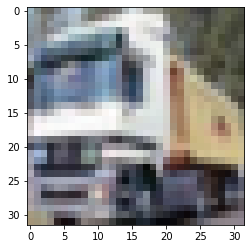

In [68]:
plt.imshow(X_curr[0])

In [69]:
X_curr_pred = model(X_curr)
X_curr_pred.numpy()

array([[1.2644829e-06, 4.8814401e-09, 1.5153264e-09, 8.4905425e-09,
        5.5130661e-10, 1.1617126e-09, 5.7728627e-10, 2.8839472e-07,
        6.1489339e-04, 9.9938357e-01]], dtype=float32)

Prediction result based on model:

In [70]:
cifar_classes[np.argmax(X_curr_pred)]

'truck'

## Deploy model

In [8]:
%%bash
kubectl apply -f - << END
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
spec:
  protocol: tensorflow
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: resnet32
    name: default
    replicas: 1
END

seldondeployment.machinelearning.seldon.io/cifar10 configured


In [20]:
!kubectl get pods | grep cifar

cifar10-default-0-resnet32-75bd765548-wqmx7   2/2     Running   0          10m
cifar10-default-explainer-64d6685bfc-t2thp    1/1     Running   0          4m14s


In [71]:
import requests
X_curr = X_train[1:2]

pred = requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                     json={ "instances": X_curr.tolist() }).json()
print(pred)

{'predictions': [[1.26448288e-06, 4.88144e-09, 1.51532642e-09, 8.49054249e-09, 5.51306611e-10, 1.16171261e-09, 5.77286274e-10, 2.88394716e-07, 0.00061489339, 0.999383569]]}


In [72]:
cifar_classes[np.argmax(pred["predictions"][0])]

'truck'

## Performance Monitoring

In [ ]:
import time
for X_i in X_test:
    requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                     json={ "instances": [X_i.tolist()] })
    time.sleep(0.1)

### Cluster Performance Metrics

![](img/k8s-perf.jpg)

### Model Performance Metrics

![](img/perf.jpg)

## Deploy Explainer

In [15]:
%%bash
kubectl apply -f - << END
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
spec:
  protocol: tensorflow
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: resnet32
    explainer:
      type: AnchorImages
      modelUri: gs://seldon-models/tfserving/cifar10/explainer-py36-0.5.2
    name: default
    replicas: 1
END

seldondeployment.machinelearning.seldon.io/cifar10 configured


In [21]:
!kubectl get pods | grep cifar

cifar10-default-0-resnet32-75bd765548-wqmx7   2/2     Running   0          11m
cifar10-default-explainer-64d6685bfc-t2thp    1/1     Running   0          4m40s


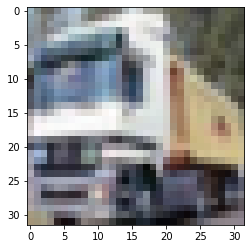

In [73]:
X_curr = X_train[1:2]

plt.imshow(X_curr[0])

In [74]:
import requests

exp = requests.post("http://localhost:80/seldon/default/cifar10-explainer/default/v1/models/resnet32:explain",
                     json={ "instances": X_curr.tolist() }).json()
print(f'Coverage: {exp["data"]["coverage"]}')
print(f'Precision: {exp["data"]["precision"]}')

Coverage: 0.2529
Precision: 1.0


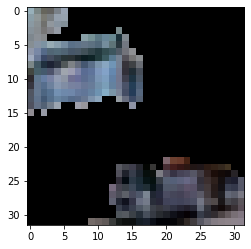

In [75]:
exp_img = np.array(exp["data"]["anchor"])
plt.imshow(exp_img)

## Enable Request Logger and Eventing

In [79]:
%%bash
kubectl apply -f - << END
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
spec:
  protocol: tensorflow
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: resnet32
      logger:
        url: http://broker-ingress.knative-eventing.svc.cluster.local/default/default
        mode: all
    explainer:
      type: AnchorImages
      modelUri: gs://seldon-models/tfserving/cifar10/explainer-py36-0.5.2
    name: default
    replicas: 1
END

seldondeployment.machinelearning.seldon.io/cifar10 configured


In [93]:
%%bash
kubectl apply -f - << END
apiVersion: apps/v1
kind: Deployment
metadata:
  name: cifar10-outlier-detector
  labels:
    app: cifar10-outlier-detector
spec:
  replicas: 1
  selector:
    matchLabels:
      app: cifar10-outlier-detector
  template:
    metadata:
      annotations:
        prometheus.io/path: "/v1/metrics"
        prometheus.io/scrape: "true"
      labels:
        app: cifar10-outlier-detector
    spec:
      securityContext:
          runAsUser: 8888
      containers:
      - name: user-container
        image: seldonio/alibi-detect-server:1.5.0-dev
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10od
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/od/OutlierVAE/cifar10
        - --reply_url
        - http://broker-ingress.knative-eventing.svc.cluster.local/default/default
        - --event_type
        - io.seldon.serving.inference.outlier
        - --event_source
        - io.seldon.serving.cifar10od
        - OutlierDetector
        ports:
        - containerPort: 8080
          name: metrics
          protocol: TCP
---
apiVersion: v1
kind: Service
metadata:
  name: cifar10-outlier-detector
  labels:
    app: cifar10-outlier-detector
spec:
  selector:
    app: cifar10-outlier-detector
  ports:
    - protocol: TCP
      port: 80
      targetPort: 8080
END

deployment.apps/cifar10-outlier-detector configured
service/cifar10-outlier-detector unchanged


In [76]:
!kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.19.0/eventing-crds.yaml
!kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.19.0/eventing-core.yaml
!kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.19.0/in-memory-channel.yaml
!kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.19.0/mt-channel-broker.yaml

customresourcedefinition.apiextensions.k8s.io/apiserversources.sources.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/brokers.eventing.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/channels.messaging.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/containersources.sources.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/eventtypes.eventing.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/parallels.flows.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/pingsources.sources.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/sequences.flows.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/sinkbindings.sources.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/subscriptions.messaging.knative.dev unchanged
customresourcedefinition.apiextensions.k8s.io/triggers.eventing.knative.dev unchanged
namespace/knative-eventing unch

In [77]:
%%bash
kubectl apply -f - << END
apiVersion: eventing.knative.dev/v1
kind: Broker
metadata:
  name: default
spec: {}
END

broker.eventing.knative.dev/default unchanged


In [78]:
!kubectl get broker

NAME      URL                                                                        AGE   READY   REASON
default   http://broker-ingress.knative-eventing.svc.cluster.local/default/default   28h   True    


In [89]:
%%bash
kubectl apply -f - << END
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: cifar10-outlier-detector-trigger
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: v1
      kind: Service
      name: cifar10-outlier-detector
END 

trigger.eventing.knative.dev/cifar10-outlier-detector-trigger configured


In [88]:
!kubectl get trigger

NAME                               BROKER    SUBSCRIBER_URI                                               AGE   READY   REASON
cifar10-outlier-detector-trigger   default   http://cifar10-outlier-detector.default.svc.cluster.local/   6s    True    


In [94]:
import requests
X_curr = X_train[1:2]

pred = requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                     json={ "instances": X_curr.tolist() }).json()
print(pred)

{'predictions': [[1.26448288e-06, 4.88144e-09, 1.51532642e-09, 8.49054249e-09, 5.51306611e-10, 1.16171261e-09, 5.77286274e-10, 2.88394716e-07, 0.00061489339, 0.999383569]]}


In [98]:
!kubectl run --quiet=true -it --rm curl --image=radial/busyboxplus:curl --restart=Never -- \
    curl -X GET -v "http://cifar10-outlier-detector.default.svc.cluster.local:80/v1/metrics"